In [1]:
import biotite.sequence as seq
import biotite.sequence.align as align
import numpy as np

alph = seq.ProteinSequence.alphabet
# 표준 단백질 치환 행렬인 BLOSUM62를 불러옵니다
matrix = align.SubstitutionMatrix.std_protein_matrix()
print("\nBLOSUM62\n")
print(matrix)
# 내부 데이터베이스에서 다른 행렬을 불러옵니다
matrix = align.SubstitutionMatrix(alph, alph, "BLOSUM50")
# 행렬의 딕셔너리 표현을 불러오고,
# 수정한 다음, SubstitutionMatrix를 생성합니다
# (딕셔너리는 대안적으로 NCBI 형식의 행렬을 포함하는 문자열에서 불러올 수 있습니다)
matrix_dict = align.SubstitutionMatrix.dict_from_db("BLOSUM62")
matrix_dict[("P", "Y")] = 100
matrix = align.SubstitutionMatrix(alph, alph, matrix_dict)
# 이제 유사성 점수를 포함하는 ndarray를 직접 제공하여 행렬을 생성합니다
# (우리의 경우 항등 행렬)
scores = np.identity(len(alph), dtype=int)
matrix = align.SubstitutionMatrix(alph, alph, scores)
print("\n\n항등 행렬\n")
print(matrix)


BLOSUM62

    A   C   D   E   F   G   H   I   K   L   M   N   P   Q   R   S   T   V   W   Y   B   Z   X   *
A   4   0  -2  -1  -2   0  -2  -1  -1  -1  -1  -2  -1  -1  -1   1   0   0  -3  -2  -2  -1   0  -4
C   0   9  -3  -4  -2  -3  -3  -1  -3  -1  -1  -3  -3  -3  -3  -1  -1  -1  -2  -2  -3  -3  -2  -4
D  -2  -3   6   2  -3  -1  -1  -3  -1  -4  -3   1  -1   0  -2   0  -1  -3  -4  -3   4   1  -1  -4
E  -1  -4   2   5  -3  -2   0  -3   1  -3  -2   0  -1   2   0   0  -1  -2  -3  -2   1   4  -1  -4
F  -2  -2  -3  -3   6  -3  -1   0  -3   0   0  -3  -4  -3  -3  -2  -2  -1   1   3  -3  -3  -1  -4
G   0  -3  -1  -2  -3   6  -2  -4  -2  -4  -3   0  -2  -2  -2   0  -2  -3  -2  -3  -1  -2  -1  -4
H  -2  -3  -1   0  -1  -2   8  -3  -1  -3  -2   1  -2   0   0  -1  -2  -3  -2   2   0   0  -1  -4
I  -1  -1  -3  -3   0  -4  -3   4  -3   2   1  -3  -3  -3  -3  -2  -1   3  -3  -1  -3  -3  -1  -4
K  -1  -3  -1   1  -3  -2  -1  -3   5  -2  -1   0  -1   1   2   0  -1  -2  -3  -2   0   1  -1  -4
L  -1  -1

In [2]:
seq1 = seq.ProteinSequence("BIQTITE")
seq2 = seq.ProteinSequence("IQLITE")
matrix = align.SubstitutionMatrix.std_protein_matrix()
print("\nLocal alignment")
alignments = align.align_optimal(seq1, seq2, matrix, local=True)
for ali in alignments:
    print(ali)
print("Global alignment")
alignments = align.align_optimal(seq1, seq2, matrix, local=False)
for ali in alignments:
    print(ali)


Local alignment
IQTITE
IQLITE
Global alignment
BIQTITE
-IQLITE


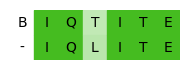

In [3]:
import matplotlib.pyplot as plt
import biotite.sequence.graphics as graphics

fig, ax = plt.subplots(figsize=(2.0, 0.8))
graphics.plot_alignment_similarity_based(
    ax, alignments[0], matrix=matrix, symbols_per_line=len(alignments[0])
)
fig.tight_layout()

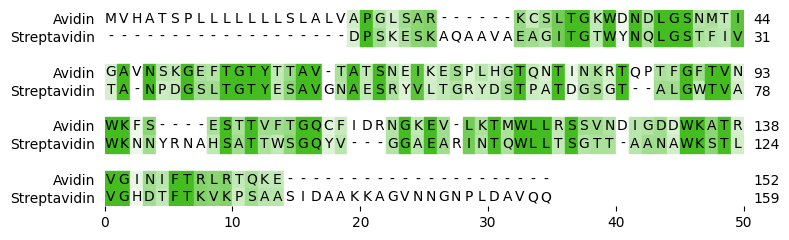

In [4]:
import matplotlib.pyplot as plt
import biotite.sequence as seq
import biotite.sequence.align as align
import biotite.sequence.io.fasta as fasta
import biotite.database.entrez as entrez
import biotite.sequence.graphics as graphics

# Download and parse protein sequences of avidin and streptavidin
fasta_file = fasta.FastaFile.read(
    entrez.fetch_single_file(["CAC34569", "ACL82594"], None, "protein", "fasta")
)
for name, sequence in fasta_file.items():
    if "CAC34569" in name:
        avidin_seq = seq.ProteinSequence(sequence)
    elif "ACL82594" in name:
        streptavidin_seq = seq.ProteinSequence(sequence)

# Get BLOSUM62 matrix
matrix = align.SubstitutionMatrix.std_protein_matrix()
# Perform pairwise sequence alignment with affine gap penalty
# Terminal gaps are not penalized
alignments = align.align_optimal(
    avidin_seq, streptavidin_seq, matrix, gap_penalty=(-10, -1), terminal_penalty=False
)

# Draw first and only alignment
# The color intensity indicates the similiarity
fig = plt.figure(figsize=(8.0, 2.5))
ax = fig.add_subplot(111)
graphics.plot_alignment_similarity_based(
    ax,
    alignments[0],
    matrix=matrix,
    labels=["Avidin", "Streptavidin"],
    show_numbers=True,
    show_line_position=True,
)
fig.tight_layout()

plt.show()

# Calculation of codon usage

This script creates a table for codon usage in the Escherichia coli K-12 strain. Codon usage describes the frequencies of the codons that code for an amino acid. These frequencies are expected to reflect the abundance of the respective tRNAs in the target organism. The codon usage differs from species to species. Hence, it is important to look at the codon usage of the organism of interest for applications like codon optimization etc.

For the computation of the codon usage we will have a look into the annotated Escherichia coli K-12 genome: The script extracts all coding sequences (CDS) from the genome and counts the total number of each codon in these sequences. Then the relative frequencies are calculated by dividing the total number of occurrences of each codon by the total number of occurrences of the respective amino acid. In order to improve the performance, the script mostly works with symbol codes (see tutorial) instead of the symbols itself.

At first we fetch the genome from the NCBI Entrez database (Accession: U00096) as GenBank file and parse it into an AnnotatedSequence. Then we create a dictionary that will store the total codon frequencies later on. As already mentioned, the script works with symbol codes. Consequently, each codon in the dictionary is described as 3 integers instead of 3 letters.

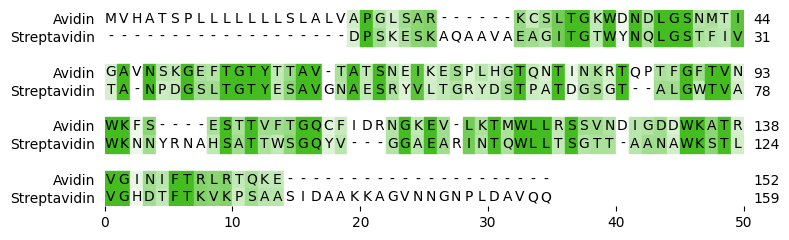

In [7]:
import matplotlib.pyplot as plt
import biotite.sequence as seq
import biotite.sequence.align as align
import biotite.sequence.io.fasta as fasta
import biotite.database.entrez as entrez
import biotite.sequence.graphics as graphics

# 아비딘과 스트렙타비딘의 단백질 서열을 다운로드하고 파싱합니다
fasta_file = fasta.FastaFile.read(
    entrez.fetch_single_file(["CAC34569", "ACL82594"], None, "protein", "fasta")
)
for name, sequence in fasta_file.items():
    if "CAC34569" in name:
        avidin_seq = seq.ProteinSequence(sequence)
    elif "ACL82594" in name:
        streptavidin_seq = seq.ProteinSequence(sequence)

# BLOSUM62 행렬을 가져옵니다
matrix = align.SubstitutionMatrix.std_protein_matrix()
# 아핀 갭 페널티를 사용하여 쌍별 서열 정렬을 수행합니다
# 말단 갭에는 페널티가 적용되지 않습니다
alignments = align.align_optimal(
    avidin_seq, streptavidin_seq, matrix, gap_penalty=(-10, -1), terminal_penalty=False
)

# 첫 번째이자 유일한 정렬을 그립니다
# 색상 강도는 유사성을 나타냅니다
fig = plt.figure(figsize=(8.0, 2.5))
ax = fig.add_subplot(111)
graphics.plot_alignment_similarity_based(
    ax,
    alignments[0],
    matrix=matrix,
    labels=["Avidin", "Streptavidin"],
    show_numbers=True,
    show_line_position=True,
)
fig.tight_layout()

plt.show()

As expected the dictionary encodes each codon as tuple of 3 numbers, where 0 represents A, 1 C, 2 G and 3 T. These mappings are defined by the alphabet of the genomic sequence.

In the next step the occurrences of codons in the coding sequences are counted, the relative frequencies are calculated and the codon table is printed.

The codon usage table can be used to optimize recombinant protein expression by designing the DNA sequence for the target protein according to the codon usage. This is called codon optimization. However, there is a variety of different algorithms for codon optimization. For simplicity reasons, this example uses an approach, where for every amino acid always the most frequently occuring codon is used.

In the follwing we will derive a codon optimized DNA sequence of streptavidin for expression in E. coli K-12.


In [8]:
# 각 아미노산에 대해 코돈 사용 빈도가 가장 높은 코돈을 선택합니다
# 여기서도 심볼 코드가 사용됩니다
opt_codons = {}
for amino_acid_code in range(20):
    codon_codes_for_aa = table[amino_acid_code]
    # 빈도가 가장 높은 코돈을 찾습니다
    max_freq = 0
    best_codon_code = None
    for codon_code in codon_codes_for_aa:
        if codon_counter[codon_code] > max_freq:
            max_freq = codon_counter[codon_code]
            best_codon_code = codon_code
    # 아미노산을 빈도가 가장 높은 코돈에 매핑합니다
    opt_codons[amino_acid_code] = best_codon_code

# Streptomyces avidinii에서 스트렙타비딘 단백질 서열을 가져옵니다
fasta_file = fasta.FastaFile.read(
    entrez.fetch("P22629", None, "fasta", "protein", "fasta")
)
strep_prot_seq = fasta.get_sequence(fasta_file)
# 최적의 코돈을 사용하여 단백질 서열로부터 DNA 서열을 생성합니다
strep_dna_seq = seq.NucleotideSequence()
strep_dna_seq.code = np.concatenate(
    [opt_codons[amino_acid_code] for amino_acid_code in strep_prot_seq.code]
)
# 종결 코돈을 추가합니다
strep_dna_seq += seq.NucleotideSequence("TAA")
# DNA 서열을 FASTA 파일에 넣습니다
fasta_file = fasta.FastaFile()
fasta_file["Codon optimized sequence"] = str(strep_dna_seq)
# 생성된 FASTA 파일의 내용을 출력합니다
print(fasta_file)
# 실제 응용에서는 다음과 같이 하드 드라이브에 쓰여질 것입니다
# fasta_file.write("../data/some_file.fasta")


>Codon optimized sequence
ATGCGCAAAATTGTGGTGGCGGCGATTGCGGTGAGCCTGACCACCGTGAGCATTACCGCGAGCGCGAGCGCGGATCCGAG
CAAAGATAGCAAAGCGCAGGTGAGCGCGGCGGAAGCGGGCATTACCGGCACCTGGTATAACCAGCTGGGCAGCACCTTTA
TTGTGACCGCGGGCGCGGATGGCGCGCTGACCGGCACCTATGAAAGCGCGGTGGGCAACGCGGAAAGCCGCTATGTGCTG
ACCGGCCGCTATGATAGCGCGCCGGCGACCGATGGCAGCGGCACCGCGCTGGGCTGGACCGTGGCGTGGAAAAACAACTA
TCGCAACGCGCATAGCGCGACCACCTGGAGCGGCCAGTATGTGGGCGGCGCGGAAGCGCGCATTAACACCCAGTGGCTGC
TGACCAGCGGCACCACCGAAGCGAACGCGTGGAAAAGCACCCTGGTGGGCCATGATACCTTTACCAAAGTGAAACCGAGC
GCGGCGAGCATTGATGCGGCGAAAAAAGCGGGCGTGAACAACGGCAACCCGCTGGATGCGGTGCAGCAGTAA
